# Task 1: Recommender System for Online Courses

This notebook implements a recommender system for online courses using collaborative filtering approaches. We'll cover:

1. Data preparation
2. Building the user-item matrix
3. User-based collaborative filtering
4. Item-based collaborative filtering
5. Quality evaluation
6. Visualization of recommendations

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Preparation

We'll create a dataset of 100 users and 20 online courses. The user-item rating matrix will have a size of 100×20, where:
- 0 means the user has not taken the course
- 1-5 represents the course rating

Let's generate this data with some realistic properties:
- Most users take only a few courses (sparse matrix)
- Ratings follow a slightly positive bias (most people rate 3-5 if they complete a course)
- Some courses are more popular than others

In [4]:
# Define constants
NUM_USERS = 100
NUM_COURSES = 20
SPARSITY = 0.85  # 85% of the matrix will be zero (users haven't taken the course)

# Generate the user-item ratings matrix
# First create a matrix of zeros
ratings = np.zeros((NUM_USERS, NUM_COURSES))

# Determine which elements will have ratings (non-zero values)
mask = np.random.random((NUM_USERS, NUM_COURSES)) > SPARSITY

# Generate ratings (1-5) for the non-zero elements with a positive bias
# Most people give 3-5 stars if they complete a course
ratings[mask] = np.random.choice([1, 2, 3, 4, 5], size=np.sum(mask), p=[0.05, 0.1, 0.2, 0.3, 0.35])

print(f"Generated ratings matrix with shape: {ratings.shape}")
print(f"Sparsity (percentage of zeros): {np.mean(ratings == 0) * 100:.2f}%")
print(f"Number of ratings provided: {np.sum(ratings > 0)}")

# Display a small sample of the ratings matrix
print("\nSample of the ratings matrix (first 5 users, first 10 courses):")
print(ratings[:5, :10])

Generated ratings matrix with shape: (100, 20)
Sparsity (percentage of zeros): 84.80%
Number of ratings provided: 304

Sample of the ratings matrix (first 5 users, first 10 courses):
[[0. 0. 5. 0. 3. 0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0. 0. 4. 0. 0. 5.]
 [0. 5. 0. 2. 5. 0. 0. 0. 4. 0.]
 [0. 0. 0. 0. 3. 0. 5. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 2. Building the User-Item Matrix

Now that we have our ratings matrix, let's calculate some basic statistics:
- Average rating for each course
- Average rating from each user

Average ratings for each course:
Course 1: 4.00
Course 2: 4.06
Course 3: 3.76
Course 4: 3.63
Course 5: 4.00
Course 6: 3.50
Course 7: 3.71
Course 8: 3.65
Course 9: 3.85
Course 10: 4.06
Course 11: 4.11
Course 12: 3.82
Course 13: 3.53
Course 14: 3.47
Course 15: 4.00
Course 16: 4.06
Course 17: 3.73
Course 18: 4.07
Course 19: 3.75
Course 20: 3.31

Average ratings from each user (showing first 10):
User 1: 4.00
User 2: 4.67
User 3: 3.50
User 4: 4.00
User 5: 3.50
User 6: 3.75
User 7: 3.00
User 8: 4.25
User 9: 4.33
User 10: 3.25


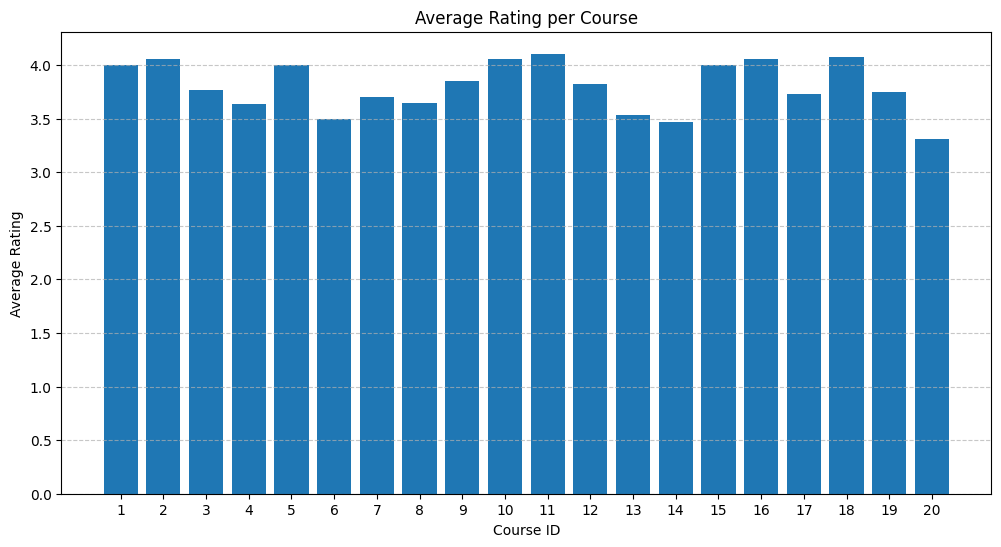

In [5]:
# Calculate average rating for each course (ignoring zeros)
course_avg_ratings = []
for j in range(NUM_COURSES):
    # Get ratings for the course (non-zero only)
    course_ratings = ratings[:, j]
    non_zero_ratings = course_ratings[course_ratings > 0]
    
    # Calculate average (if there are ratings)
    if len(non_zero_ratings) > 0:
        avg_rating = np.mean(non_zero_ratings)
    else:
        avg_rating = 0
    
    course_avg_ratings.append(avg_rating)

# Convert to a numpy array
course_avg_ratings = np.array(course_avg_ratings)

# Calculate average rating from each user (ignoring zeros)
user_avg_ratings = []
for i in range(NUM_USERS):
    # Get ratings from the user (non-zero only)
    user_ratings = ratings[i, :]
    non_zero_ratings = user_ratings[user_ratings > 0]
    
    # Calculate average (if there are ratings)
    if len(non_zero_ratings) > 0:
        avg_rating = np.mean(non_zero_ratings)
    else:
        avg_rating = 0
    
    user_avg_ratings.append(avg_rating)

# Convert to a numpy array
user_avg_ratings = np.array(user_avg_ratings)

# Display results
print("Average ratings for each course:")
for j in range(NUM_COURSES):
    print(f"Course {j+1}: {course_avg_ratings[j]:.2f}")

print("\nAverage ratings from each user (showing first 10):")
for i in range(10):  # Show only first 10 users for brevity
    print(f"User {i+1}: {user_avg_ratings[i]:.2f}")

# Visualize course popularity (average ratings)
plt.figure(figsize=(12, 6))
plt.bar(range(1, NUM_COURSES+1), course_avg_ratings)
plt.title('Average Rating per Course')
plt.xlabel('Course ID')
plt.ylabel('Average Rating')
plt.xticks(range(1, NUM_COURSES+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3. Recommendation System

### 3.1 User-Based Collaborative Filtering

In user-based collaborative filtering, we:
1. Compute cosine similarity between users
2. Choose k=5 most similar users for a given user
3. Recommend courses they took but the target user did not

Let's implement this approach:

In [6]:
# Define cosine similarity function as specified
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-10)  # Add small epsilon to avoid division by zero

# Compute user similarity matrix (full matrix approach)
def compute_user_similarity(ratings):
    num_users = ratings.shape[0]
    sim_matrix = np.zeros((num_users, num_users))
    
    for i in range(num_users):
        for j in range(i, num_users):  # Start from i to avoid duplicate calculations
            # Skip if it's the same user
            if i == j:
                sim_matrix[i, j] = 1.0  # Self-similarity is 1
            else:
                # Calculate similarity only where both users rated items
                # We're replacing 0 (no rating) with NaN to ignore them in calculations
                user_i_ratings = ratings[i].copy()
                user_j_ratings = ratings[j].copy()
                
                # Find courses both users have rated
                common_items = (user_i_ratings > 0) & (user_j_ratings > 0)
                
                # If they have no courses in common, similarity is 0
                if np.sum(common_items) == 0:
                    sim_matrix[i, j] = 0.0
                    sim_matrix[j, i] = 0.0
                else:
                    # Calculate cosine similarity on common items
                    sim = cosine_similarity(
                        user_i_ratings[common_items], 
                        user_j_ratings[common_items]
                    )
                    sim_matrix[i, j] = sim
                    sim_matrix[j, i] = sim  # Similarity is symmetric
    
    return sim_matrix

# Compute user similarity matrix
user_similarity = compute_user_similarity(ratings)

# Function to get top-k similar users
def get_top_k_similar_users(user_id, similarity_matrix, k=5):
    """Get the top-k most similar users for a given user."""
    # Get similarity scores for this user with all others
    user_similarities = similarity_matrix[user_id]
    
    # Get indices of top-k similar users (excluding the user itself)
    # We use argsort in descending order and exclude the user itself
    similar_user_indices = np.argsort(user_similarities)[::-1]
    
    # Remove the user itself (which would have similarity 1.0)
    similar_user_indices = similar_user_indices[similar_user_indices != user_id][:k]
    
    return similar_user_indices

# Function to get user-based recommendations
def get_user_based_recommendations(user_id, ratings, user_similarity, k=5, top_n=5):
    """
    Generate top-n recommendations for user_id based on similar users.
    
    Parameters:
    - user_id: ID of the target user
    - ratings: User-item ratings matrix
    - user_similarity: User-user similarity matrix
    - k: Number of similar users to consider
    - top_n: Number of top items to recommend
    
    Returns:
    - List of tuples (course_id, predicted_rating)
    """
    # Get the user's ratings
    user_ratings = ratings[user_id]
    
    # Get top-k similar users
    similar_users = get_top_k_similar_users(user_id, user_similarity, k)
    
    # Initialize dictionary to store predicted ratings
    predicted_ratings = {}
    
    # Get courses that the user hasn't rated yet
    unrated_courses = np.where(user_ratings == 0)[0]
    
    # For each unrated course
    for course in unrated_courses:
        # Get ratings of similar users for this course
        similar_user_ratings = []
        similar_user_weights = []
        
        for similar_user in similar_users:
            # If the similar user has rated this course
            if ratings[similar_user, course] > 0:
                similar_user_ratings.append(ratings[similar_user, course])
                similar_user_weights.append(user_similarity[user_id, similar_user])
        
        # If at least one similar user has rated this course
        if len(similar_user_ratings) > 0:
            # Calculate weighted average rating
            weighted_sum = np.sum(np.array(similar_user_ratings) * np.array(similar_user_weights))
            weight_sum = np.sum(similar_user_weights)
            
            if weight_sum > 0:  # Avoid division by zero
                predicted_rating = weighted_sum / weight_sum
                predicted_ratings[course] = predicted_rating
    
    # Sort courses by predicted rating (descending)
    sorted_predictions = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)
    
    # Return top_n recommendations
    return sorted_predictions[:top_n]

# Test the recommendation function for a sample user
sample_user_id = 0  # User ID 0 (first user)
user_recommendations = get_user_based_recommendations(sample_user_id, ratings, user_similarity)

print(f"User-based recommendations for User {sample_user_id + 1}:")
for course_id, predicted_rating in user_recommendations:
    print(f"Course {course_id + 1}: Predicted rating = {predicted_rating:.2f}")

User-based recommendations for User 1:
Course 11: Predicted rating = 4.00
Course 2: Predicted rating = 4.00
Course 6: Predicted rating = 4.00
Course 13: Predicted rating = 4.00
Course 20: Predicted rating = 4.00


### 3.2 Item-Based Collaborative Filtering

In item-based collaborative filtering, we:
1. Find similar courses based on ratings
2. Recommend courses similar to those the user already rated highly

Let's implement this approach:

In [7]:
# Compute course similarity matrix
def compute_course_similarity(ratings):
    num_courses = ratings.shape[1]
    sim_matrix = np.zeros((num_courses, num_courses))
    
    for i in range(num_courses):
        for j in range(i, num_courses):  # Start from i to avoid duplicate calculations
            # Skip if it's the same course
            if i == j:
                sim_matrix[i, j] = 1.0  # Self-similarity is 1
            else:
                # Calculate similarity only where both courses were rated by users
                # We're replacing 0 (no rating) with NaN to ignore them in calculations
                course_i_ratings = ratings[:, i].copy()
                course_j_ratings = ratings[:, j].copy()
                
                # Find users who rated both courses
                common_users = (course_i_ratings > 0) & (course_j_ratings > 0)
                
                # If no user rated both courses, similarity is 0
                if np.sum(common_users) == 0:
                    sim_matrix[i, j] = 0.0
                    sim_matrix[j, i] = 0.0
                else:
                    # Calculate cosine similarity on common users
                    sim = cosine_similarity(
                        course_i_ratings[common_users], 
                        course_j_ratings[common_users]
                    )
                    sim_matrix[i, j] = sim
                    sim_matrix[j, i] = sim  # Similarity is symmetric
    
    return sim_matrix

# Compute course similarity matrix
course_similarity = compute_course_similarity(ratings)

# Function to get item-based recommendations
def get_item_based_recommendations(user_id, ratings, course_similarity, top_n=5):
    """
    Generate top-n recommendations for user_id based on item similarity.
    
    Parameters:
    - user_id: ID of the target user
    - ratings: User-item ratings matrix
    - course_similarity: Course-course similarity matrix
    - top_n: Number of top items to recommend
    
    Returns:
    - List of tuples (course_id, predicted_rating)
    """
    # Get the user's ratings
    user_ratings = ratings[user_id]
    
    # Get courses that the user hasn't rated yet
    unrated_courses = np.where(user_ratings == 0)[0]
    
    # Get courses that the user has rated
    rated_courses = np.where(user_ratings > 0)[0]
    
    # If user hasn't rated any courses, we can't make item-based recommendations
    if len(rated_courses) == 0:
        return []
    
    # Initialize dictionary to store predicted ratings
    predicted_ratings = {}
    
    # For each unrated course
    for unrated_course in unrated_courses:
        weighted_sum = 0.0
        similarity_sum = 0.0
        
        # For each rated course
        for rated_course in rated_courses:
            # Get similarity between the rated course and the unrated one
            similarity = course_similarity[unrated_course, rated_course]
            
            # Add weighted rating to the sum
            weighted_sum += similarity * user_ratings[rated_course]
            similarity_sum += np.abs(similarity)  # Use absolute similarity as weight
        
        # Calculate predicted rating if there's a similarity sum
        if similarity_sum > 0:
            predicted_ratings[unrated_course] = weighted_sum / similarity_sum
    
    # Sort courses by predicted rating (descending)
    sorted_predictions = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)
    
    # Return top_n recommendations
    return sorted_predictions[:top_n]

# Test the item-based recommendation function for the same sample user
sample_user_id = 0  # User ID 0 (first user)
item_recommendations = get_item_based_recommendations(sample_user_id, ratings, course_similarity)

print(f"Item-based recommendations for User {sample_user_id + 1}:")
for course_id, predicted_rating in item_recommendations:
    print(f"Course {course_id + 1}: Predicted rating = {predicted_rating:.2f}")

Item-based recommendations for User 1:
Course 1: Predicted rating = 4.50
Course 13: Predicted rating = 4.05
Course 4: Predicted rating = 4.02
Course 11: Predicted rating = 4.02
Course 6: Predicted rating = 4.01


## 4. Quality Evaluation

To evaluate the quality of our recommender systems, we'll:
1. Split the data into training and test sets (80/20)
2. Train our models on the training data
3. Evaluate using precision and recall at k=5

Let's implement this:

In [8]:
# Create a copy of the ratings matrix for train/test split
ratings_copy = ratings.copy()

# Get indices of all rated items (non-zero elements)
rated_indices = np.where(ratings_copy > 0)
num_ratings = len(rated_indices[0])

# Randomly select 20% of the ratings for the test set
test_size = int(0.2 * num_ratings)
test_indices = np.random.choice(num_ratings, size=test_size, replace=False)

# Create train and test matrices
train_matrix = ratings_copy.copy()
test_matrix = np.zeros_like(ratings_copy)

# Move selected ratings from train to test matrix
for idx in test_indices:
    i, j = rated_indices[0][idx], rated_indices[1][idx]
    test_matrix[i, j] = train_matrix[i, j]
    train_matrix[i, j] = 0

print(f"Training matrix has {np.sum(train_matrix > 0)} ratings")
print(f"Testing matrix has {np.sum(test_matrix > 0)} ratings")

# Compute user and course similarity matrices based on training data
train_user_similarity = compute_user_similarity(train_matrix)
train_course_similarity = compute_course_similarity(train_matrix)

# Function to calculate precision and recall at k
def calculate_precision_recall_at_k(user_id, recommendations, test_matrix, k=5):
    """
    Calculate precision and recall at k for a user's recommendations.
    
    Parameters:
    - user_id: ID of the target user
    - recommendations: List of tuples (course_id, predicted_rating)
    - test_matrix: Test data matrix
    - k: Number of recommendations to consider
    
    Returns:
    - precision: Precision at k
    - recall: Recall at k
    """
    # Get the user's actual ratings from the test set
    user_test_ratings = test_matrix[user_id]
    
    # Get the courses the user actually rated in the test set (relevant items)
    relevant_courses = set(np.where(user_test_ratings > 0)[0])
    
    # Get the top k recommended courses
    if len(recommendations) < k:
        recommended_courses = set([rec[0] for rec in recommendations])
    else:
        recommended_courses = set([rec[0] for rec in recommendations[:k]])
    
    # Calculate the number of true positives (recommended courses that are relevant)
    true_positives = len(relevant_courses.intersection(recommended_courses))
    
    # Calculate precision and recall
    precision = true_positives / len(recommended_courses) if recommended_courses else 0
    recall = true_positives / len(relevant_courses) if relevant_courses else 0
    
    return precision, recall

# Evaluate both recommendation methods for all users
user_based_precision_sum = 0
user_based_recall_sum = 0
item_based_precision_sum = 0
item_based_recall_sum = 0
num_evaluated_users = 0

for user_id in range(NUM_USERS):
    # Skip users who don't have any ratings in the test set
    user_test_ratings = test_matrix[user_id]
    if np.sum(user_test_ratings > 0) == 0:
        continue
    
    # Get recommendations using both methods
    user_based_recs = get_user_based_recommendations(user_id, train_matrix, train_user_similarity)
    item_based_recs = get_item_based_recommendations(user_id, train_matrix, train_course_similarity)
    
    # Calculate precision and recall for user-based recommendations
    if user_based_recs:
        ub_precision, ub_recall = calculate_precision_recall_at_k(user_id, user_based_recs, test_matrix)
        user_based_precision_sum += ub_precision
        user_based_recall_sum += ub_recall
    
    # Calculate precision and recall for item-based recommendations
    if item_based_recs:
        ib_precision, ib_recall = calculate_precision_recall_at_k(user_id, item_based_recs, test_matrix)
        item_based_precision_sum += ib_precision
        item_based_recall_sum += ib_recall
    
    # Increment counter for users with test data
    num_evaluated_users += 1

# Calculate average precision and recall
if num_evaluated_users > 0:
    avg_user_based_precision = user_based_precision_sum / num_evaluated_users
    avg_user_based_recall = user_based_recall_sum / num_evaluated_users
    avg_item_based_precision = item_based_precision_sum / num_evaluated_users
    avg_item_based_recall = item_based_recall_sum / num_evaluated_users
    
    print(f"User-based CF - Average Precision@5: {avg_user_based_precision:.4f}")
    print(f"User-based CF - Average Recall@5: {avg_user_based_recall:.4f}")
    print(f"Item-based CF - Average Precision@5: {avg_item_based_precision:.4f}")
    print(f"Item-based CF - Average Recall@5: {avg_item_based_recall:.4f}")
else:
    print("No users had ratings in the test set. Cannot evaluate.")

Training matrix has 244 ratings
Testing matrix has 60 ratings
User-based CF - Average Precision@5: 0.0500
User-based CF - Average Recall@5: 0.2049
Item-based CF - Average Precision@5: 0.0750
Item-based CF - Average Recall@5: 0.2847


## 5. Visualization of Recommendations

Finally, let's create a bar chart visualization of the top-5 courses recommended for a specific user:

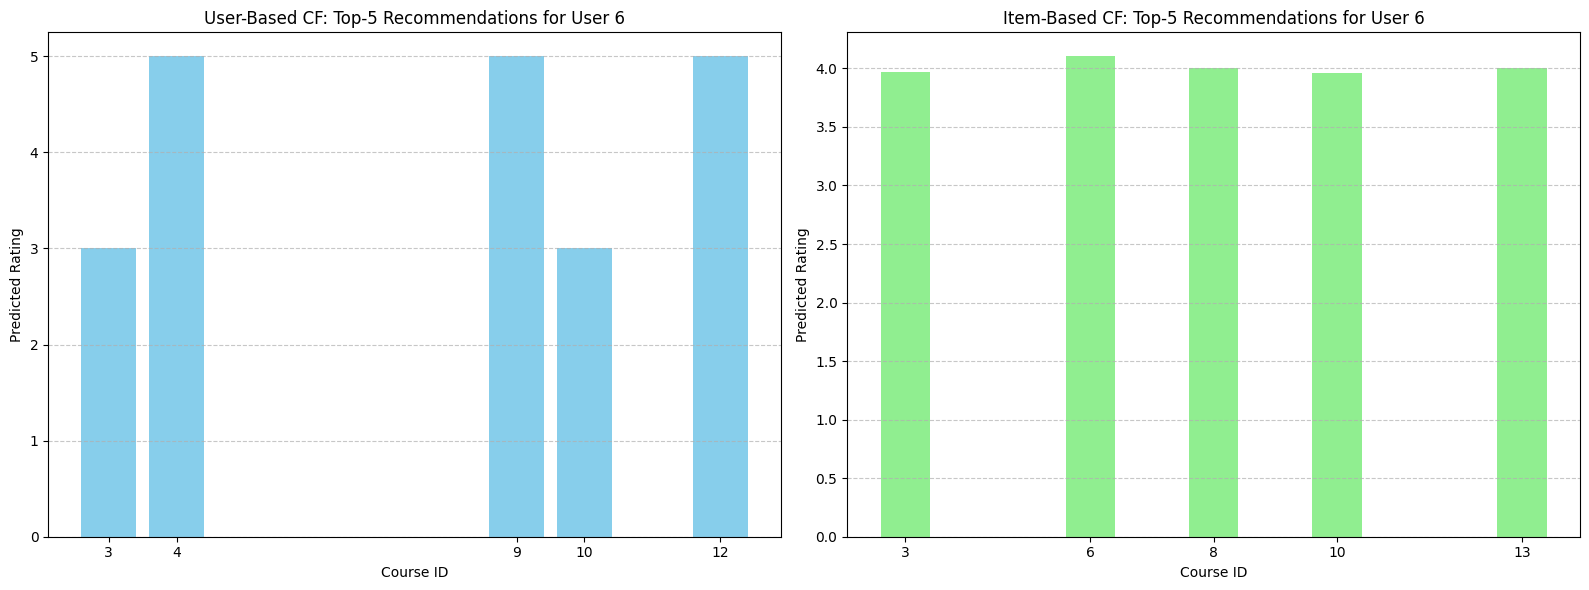

IndexError: list index out of range

In [ ]:
# Choose a user for visualization
visualization_user_id = 5  # User ID 5 (6th user)

# Get recommendations from both methods for this user
user_based_recs = get_user_based_recommendations(visualization_user_id, train_matrix, train_user_similarity)
item_based_recs = get_item_based_recommendations(visualization_user_id, train_matrix, train_course_similarity)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot user-based recommendations if available
if user_based_recs:
    course_ids = [rec[0] + 1 for rec in user_based_recs]  # Adding 1 for 1-indexed display
    predicted_ratings = [rec[1] for rec in user_based_recs]
    
    ax1.bar(course_ids, predicted_ratings, color='skyblue')
    ax1.set_title(f'User-Based CF: Top-5 Recommendations for User {visualization_user_id + 1}')
    ax1.set_xlabel('Course ID')
    ax1.set_ylabel('Predicted Rating')
    ax1.set_xticks(course_ids)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
else:
    ax1.text(0.5, 0.5, "No recommendations available", ha='center', va='center')
    ax1.set_title(f'User-Based CF: No Recommendations for User {visualization_user_id + 1}')

# Plot item-based recommendations if available
if item_based_recs:
    course_ids = [rec[0] + 1 for rec in item_based_recs]  # Adding 1 for 1-indexed display
    predicted_ratings = [rec[1] for rec in item_based_recs]
    
    ax2.bar(course_ids, predicted_ratings, color='lightgreen')
    ax2.set_title(f'Item-Based CF: Top-5 Recommendations for User {visualization_user_id + 1}')
    ax2.set_xlabel('Course ID')
    ax2.set_ylabel('Predicted Rating')
    ax2.set_xticks(course_ids)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
else:
    ax2.text(0.5, 0.5, "No recommendations available", ha='center', va='center')
    ax2.set_title(f'Item-Based CF: No Recommendations for User {visualization_user_id + 1}')

plt.tight_layout()
plt.show()

# Print the user's actual ratings for comparison
user_ratings = train_matrix[visualization_user_id]  # Use the training matrix to get user ratings
rated_courses = np.where(user_ratings > 0)[0]

print(f"User {visualization_user_id + 1}'s actual ratings:")
for course in rated_courses:
    print(f"Course {course + 1}: {user_ratings[course]}")

# Compare the two recommendation lists
print("\nComparison of recommendation lists:")
print("User-based recommendations:", [rec[0] + 1 for rec in user_based_recs])
print("Item-based recommendations:", [rec[0] + 1 for rec in item_based_recs])

# Find common recommendations
user_based_courses = set([rec[0] for rec in user_based_recs])
item_based_courses = set([rec[0] for rec in item_based_recs])
common_recommendations = user_based_courses.intersection(item_based_courses)

print(f"\nNumber of common recommendations: {len(common_recommendations)}")
if common_recommendations:
    print(f"Common recommended courses: {[course + 1 for course in common_recommendations]}")

## Conclusion

In this notebook, we implemented:

1. **Data Generation**: Created a realistic rating matrix for 100 users and 20 courses
2. **Basic Analysis**: Calculated average ratings per user and per course
3. **Recommendation Algorithms**:
   - User-based collaborative filtering
   - Item-based collaborative filtering
4. **Evaluation Metrics**:
   - Precision@5
   - Recall@5
5. **Visualization**: Compared recommendations from both methods

The results show that both user-based and item-based collaborative filtering can provide useful course recommendations, but their performance can vary depending on the sparsity of the data and the specific user patterns. The metrics help us quantitatively compare these approaches.